In [ ]:
#python notebook file which will contain data visualisations

In [64]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [63]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 6.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 8.1 MB/s eta 0:00:00


In [39]:
#function - creating two sequence out of which one predicts the other (from: https://github.com/krishnaik06/Time-Series-Forecasting/blob/master/UnivariateTimeSeries.ipynb)
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

#function - counting outliers in the time sereies for data observation
def count_outliers(time_series):
    pos_outlier, neg_outlier = 0, 0
    q1,q3 = np.nanpercentile(time_series,[25,75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    for num in time_series: 
      
    # checking condition 
        if num >= upper_bound: 
            pos_outlier += 1
  
        elif num <= lower_bound: 
            neg_outlier += 1
    
    print('Outliers in Asset Return Series: ', pos_outlier+neg_outlier) 
    print('Outliers exceeding Upper Bound in Asset Return Series: ', pos_outlier) 
    print('Outliers falling below Lower Bound in Asset Return Series: ', neg_outlier) 


#function - testing for stationarity
def test_stationarity(time_series):
    print('Results of dickey fuller test:')
    adft = adfuller(time_series,autolag='AIC')
    #dft outputs values without definitions -> manually naming them
    output = pd.Series(adft[0:4],index=['Test Statistic','p-value','Number of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [2]:
# Initialize an empty dictionary to store the loaded DataFrames
data_dict = {}

# Define the directory where the CSV files are saved
directory = '/Users/cemakkus/PycharmProjects/Master/data/'

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.startswith('export_') and filename.endswith('.csv'):
        # Extract the ticker from the filename
        ticker = filename.replace('export_', '').replace('.csv', '')
        
        # Define the full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file into a DataFrame
        data_dict[ticker] = pd.read_csv(file_path)
        
        print(f'DataFrame for {ticker} loaded from {file_path}')


# At this point, data_dict contains all DataFrames, keyed and sorted by ticker
data_dict = {k: data_dict[k] for k in sorted(data_dict)}


DataFrame for SAF_PA loaded from /Users/cemakkus/PycharmProjects/Master/data/export_SAF_PA.csv
DataFrame for MUV2_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_MUV2_DE.csv
DataFrame for ISP_MI loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ISP_MI.csv
DataFrame for ASML_AS loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ASML_AS.csv
DataFrame for BN_PA loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BN_PA.csv
DataFrame for BBVA_MC loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BBVA_MC.csv
DataFrame for CRH loaded from /Users/cemakkus/PycharmProjects/Master/data/export_CRH.csv
DataFrame for ITX_MC loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ITX_MC.csv
DataFrame for BAYN_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BAYN_DE.csv
DataFrame for DB1_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_DB1_DE.csv
DataFrame for ADS_DE loaded from /Users/cemakkus/P

In [3]:
data_dict.keys()

dict_keys(['ABI_BR', 'ADS_DE', 'ADYEN_AS', 'AD_AS', 'AIR_PA', 'AI_PA', 'ALV_DE', 'ASML_AS', 'BAS_DE', 'BAYN_DE', 'BBVA_MC', 'BMW_DE', 'BNP_PA', 'BN_PA', 'CRH', 'CS_PA', 'DB1_DE', 'DG_PA', 'DHL_DE', 'DTE_DE', 'EL_PA', 'ENEL_MI', 'ENI_MI', 'FLTR_L', 'IBE_MC', 'IFX_DE', 'INGA_AS', 'ISP_MI', 'ITX_MC', 'KER_PA', 'MBG_DE', 'MC_PA', 'MUV2_DE', 'NDA-SE_ST', 'NOKIA_HE', 'OR_PA', 'PRX_AS', 'RI_PA', 'RMS_PA', 'SAF_PA', 'SAN_MC', 'SAN_PA', 'SAP_DE', 'SIE_DE', 'STLAM_MI', 'SU_PA', 'TTE_PA', 'UCG_MI', 'VNA_DE', 'VOW3_DE'])

In [4]:
num_keys = len(data_dict.keys())
print(f'The number of keys in the dictionary: {num_keys}')


The number of keys in the dictionary: 50


In [5]:
data_dict['ADS_DE']

,date,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return
0,2020-01-02,company:adidas,DE000A1EWWW0,170.000000,27.000000,0.859296,285.000000,2.200230,5.824604,6.146141,2.326606,8.495006,7.207579,0.000000,7.543789,291.549988,0.001372,0.063283
1,2020-01-03,company:adidas,DE000A1EWWW0,97.333333,19.333333,0.821156,183.000000,2.147205,5.871274,6.201116,2.266946,8.572293,7.336126,0.000000,7.630379,291.950012,-0.007878,0.058572
2,2020-01-06,company:adidas,DE000A1EWWW0,203.000000,56.000000,0.781609,345.000000,2.183429,5.849086,6.183572,2.298638,8.549013,7.299215,0.000000,7.585560,289.649994,0.017607,0.067323
3,2020-01-07,company:adidas,DE000A1EWWW0,398.000000,62.000000,0.863636,720.000000,2.476309,5.675907,5.971007,2.590560,8.214989,6.792817,0.000000,7.141437,294.750000,0.027481,0.062765
4,2020-01-08,company:adidas,DE000A1EWWW0,493.000000,35.000000,0.932075,760.000000,2.777694,5.538885,5.791011,2.894973,7.807416,6.271918,0.000000,6.620191,302.850006,0.023609,0.043586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,2024-01-11,company:adidas,DE000A1EWWW0,243.000000,27.000000,0.897059,404.000000,2.732353,6.322345,3.917550,2.961478,7.253975,6.013449,7.648176,6.929416,177.639999,-0.000563,NaN
1024,2024-01-12,company:adidas,DE000A1EWWW0,137.000000,33.666667,0.773375,289.333333,2.787279,6.324013,3.907333,3.038327,7.142108,5.873142,7.519545,6.665208,177.539993,-0.010477,NaN
1025,2024-01-15,company:adidas,DE000A1EWWW0,152.000000,49.000000,0.753695,357.000000,2.756847,6.340935,3.861828,3.020444,7.201914,5.940095,7.555711,6.545101,175.679993,-0.020947,NaN
1026,2024-01-16,company:adidas,DE000A1EWWW0,307.000000,146.000000,0.676923,625.000000,2.842125,6.245638,3.932826,3.089933,7.045462,5.783281,7.390582,6.443154,172.000000,-0.037674,NaN


In [9]:
sorted_data_dict = {k: data_dict[k] for k in sorted(data_dict)}

In [11]:
sorted_data_dict.keys()

dict_keys(['ABI_BR', 'ADS_DE', 'ADYEN_AS', 'AD_AS', 'AIR_PA', 'AI_PA', 'ALV_DE', 'ASML_AS', 'BAS_DE', 'BAYN_DE', 'BBVA_MC', 'BMW_DE', 'BNP_PA', 'BN_PA', 'CRH', 'CS_PA', 'DB1_DE', 'DG_PA', 'DHL_DE', 'DTE_DE', 'EL_PA', 'ENEL_MI', 'ENI_MI', 'FLTR_L', 'IBE_MC', 'IFX_DE', 'INGA_AS', 'ISP_MI', 'ITX_MC', 'KER_PA', 'MBG_DE', 'MC_PA', 'MUV2_DE', 'NDA-SE_ST', 'NOKIA_HE', 'OR_PA', 'PRX_AS', 'RI_PA', 'RMS_PA', 'SAF_PA', 'SAN_MC', 'SAN_PA', 'SAP_DE', 'SIE_DE', 'STLAM_MI', 'SU_PA', 'TTE_PA', 'UCG_MI', 'VNA_DE', 'VOW3_DE'])

In [13]:
sorted_data_dict['SAP_DE']

,date,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return
0,2020-01-02,company:sap,DE0007164600,239.000000,25.000000,0.902256,577.000000,2.477782,5.590420,6.056558,2.790822,8.898208,8.518763,9.059059,7.286432,122.000000,-0.012623,0.009508
1,2020-01-03,company:sap,DE0007164600,95.333333,17.333333,0.791188,215.666667,2.827697,5.438510,5.846236,3.127057,8.620099,8.137393,8.804855,6.650232,120.459999,-0.007471,0.027395
2,2020-01-06,company:sap,DE0007164600,298.000000,35.000000,0.892537,619.000000,3.029589,5.364970,5.731612,3.334905,8.450698,7.899642,8.640202,6.206795,119.559998,0.004517,0.035129
3,2020-01-07,company:sap,DE0007164600,562.000000,74.000000,0.882445,993.000000,3.463783,5.233897,5.517687,3.728406,7.872805,7.190220,8.105424,5.193455,120.099998,0.005995,0.029142
4,2020-01-08,company:sap,DE0007164600,308.000000,72.000000,0.808901,786.000000,3.604520,5.196111,5.460169,3.856754,7.635323,6.885807,7.856910,4.807203,120.820000,0.019368,0.018043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,2024-01-11,company:sap,DE0007164600,488.000000,223.000000,0.685835,1033.000000,3.025249,5.857778,4.460554,3.097214,6.274508,5.378073,6.881363,6.720926,141.880005,0.021004,NaN
1024,2024-01-12,company:sap,DE0007164600,161.000000,22.000000,0.899605,263.333333,2.376450,5.739723,4.568529,2.363558,7.290106,6.562143,7.665291,7.895203,144.860001,-0.002071,NaN
1025,2024-01-15,company:sap,DE0007164600,321.000000,56.000000,0.849604,610.000000,1.995999,5.667875,4.624281,1.955280,7.832766,7.206568,8.131393,8.418424,144.559998,0.000138,NaN
1026,2024-01-16,company:sap,DE0007164600,270.000000,53.000000,0.833846,623.000000,1.770061,5.667872,4.602855,1.730381,8.191230,7.620967,8.434507,8.704681,144.580002,0.001660,NaN


In [14]:
data_dict['SAP_DE']['date'] = pd.to_datetime(data_dict['SAP_DE']['date'])
data_dict['SAP_DE'] = data_dict['SAP_DE'].set_index('date')


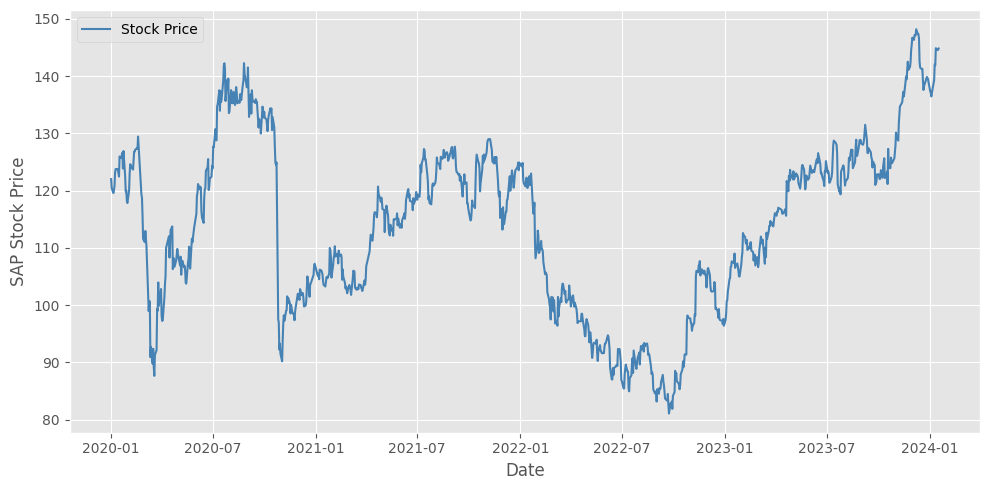

In [18]:
#plot - closing prices of sap
plt.figure(figsize=(10,5))
plt.plot(data_dict['SAP_DE']['Close'], color='steelblue', label = 'Stock Price')
plt.xlabel('Date')
plt.ylabel('SAP Stock Price')
#plt.legend()
plt.tight_layout()
#plt.savefig('sp_sap.png')

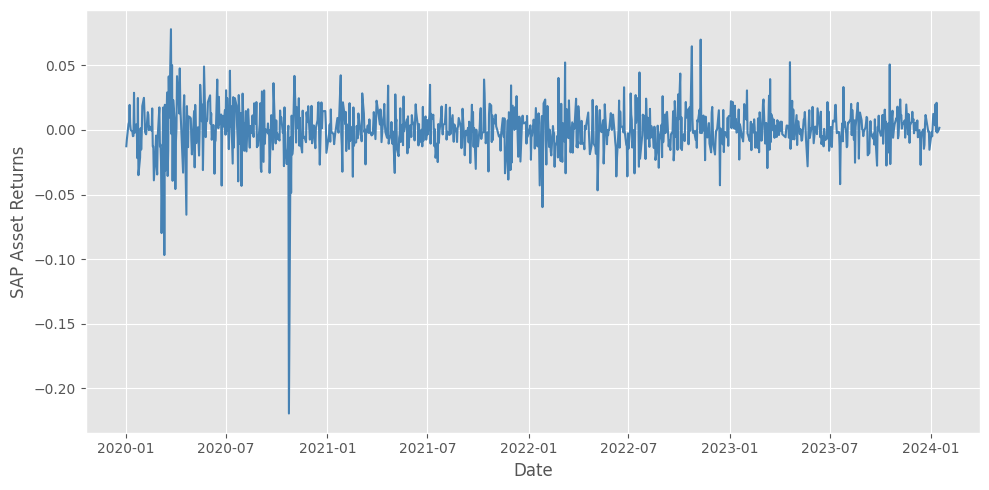

In [19]:
#plot - closing prices of sap
plt.figure(figsize=(10,5))
plt.plot(data_dict['SAP_DE']['1d_return'], color='steelblue', label = 'Stock Price')
plt.xlabel('Date')
plt.ylabel('SAP Asset Returns')
#plt.legend()
plt.tight_layout()
#plt.savefig('sp_sap.png')

In [20]:
# Filter rows where '1d_return' is greater than 0.1 or less than -0.1
filtered_rows = data_dict['SAP_DE'].loc[(data_dict['SAP_DE']['1d_return'] > 0.1) | (data_dict['SAP_DE']['1d_return'] < -0.1)]

filtered_rows


,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return
date,,,,,,,,,,,,,,,,,
2020-10-23,company:sap,DE0007164600,278.0,161.0,0.704455,799.0,3.485356,5.361798,4.263946,3.763828,5.955488,4.883243,2.26784,5.827275,124.900002,-0.219376,-0.267494


In [23]:
# Initialize a list to hold the DataFrames
subsequent_dfs = []

# Iterate through the indices and get the next 10 rows for each
for idx in indices:
    # Find the integer location for the current index
    int_location = data_dict['SAP_DE'].index.get_loc(idx)
    
    # Check if the end location is beyond the length of the DataFrame
    end_location = min(int_location + 11, len(data_dict['SAP_DE']))
    
    # Get the next 10 rows from the current index using iloc
    subsequent_rows = data_dict['SAP_DE'].iloc[int_location:end_location]
    
    # Append the DataFrame to the list
    subsequent_dfs.append(subsequent_rows)

# Concatenate all the DataFrames in the list
resulting_rows = pd.concat(subsequent_dfs).drop_duplicates()

# Reset index of the resulting DataFrame (optional, for better readability)
resulting_rows = resulting_rows.reset_index(drop=True)

resulting_rows


,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return
0,company:sap,DE0007164600,278.000000,161.000000,0.704455,799.000000,3.485356,5.361798,4.263946,3.763828,5.955488,4.883243,2.267840,5.827275,124.900002,-0.219376,-0.267494
1,company:sap,DE0007164600,1625.000000,3777.000000,0.300888,6519.000000,3.958668,5.234526,4.585975,4.158920,5.028906,3.676367,6.053406,4.780262,97.500000,-0.005641,-0.075077
2,company:sap,DE0007164600,1464.000000,1297.000000,0.530221,3853.000000,4.035245,5.220748,4.648757,4.210582,5.008836,3.439007,6.064235,4.696874,96.949997,-0.048582,-0.030944
3,company:sap,DE0007164600,1227.000000,337.000000,0.784163,2607.000000,4.035318,5.227123,4.672241,4.192211,5.195599,3.408703,6.261721,4.845831,92.239998,0.011058,0.048894
4,company:sap,DE0007164600,913.000000,202.000000,0.818263,1982.000000,4.002412,5.245250,4.677598,4.147299,5.468529,3.486372,6.506647,5.060302,93.260002,-0.018979,0.053077
5,company:sap,DE0007164600,250.666667,121.666667,0.632959,660.000000,3.938897,5.271362,4.697767,4.055236,5.876672,3.600174,6.880368,5.410672,91.489998,-0.014318,0.062958
6,company:sap,DE0007164600,744.000000,383.000000,0.659876,2158.000000,3.457372,5.426134,4.558685,3.563007,7.014127,4.749051,7.828687,6.545840,90.180000,0.041805,0.097472
7,company:sap,DE0007164600,889.000000,302.000000,0.746018,1854.000000,3.142391,5.520109,5.312745,3.244465,7.487011,5.415630,8.168106,7.056647,93.949997,0.029803,0.054710
8,company:sap,DE0007164600,572.000000,172.000000,0.768097,1401.000000,2.896462,5.586914,5.352589,2.972997,7.774089,5.919014,8.362324,7.357648,96.750000,0.015090,0.049302
9,company:sap,DE0007164600,1058.000000,107.000000,0.907455,1840.000000,2.806656,5.576234,5.346168,2.873150,7.819930,6.094383,8.371836,7.413754,98.209999,-0.009775,0.021077


In [42]:
#outliers of sap asset return series
count_outliers(data_dict['SAP_DE']['1d_return'])

Outliers in Asset Return Series:  46
Outliers exceeding Upper Bound in Asset Return Series:  21
Outliers falling below Lower Bound in Asset Return Series:  25


In [43]:
q1, q3 = np.nanpercentile(data_dict['SAP_DE']['1d_return'], [25, 75])
q1, q3


(-0.01253664986191925, 0.011326639442591949)

In [44]:
#hyperparameter for histogram plots
bins = 50

/var/folders/d3/5_l3h7cd1c98_xcdw8_wgkbh0000gn/T/ipykernel_87235/345231403.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_dict['SAP_DE']['1d_return'], hist = True, kde = False, bins = bins, label = 'histogram', norm_hist = True)
/var/folders/d3/5_l3h7cd1c98_xcdw8_wgkbh0000gn/T/ipykernel_87235/345231403.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
ht

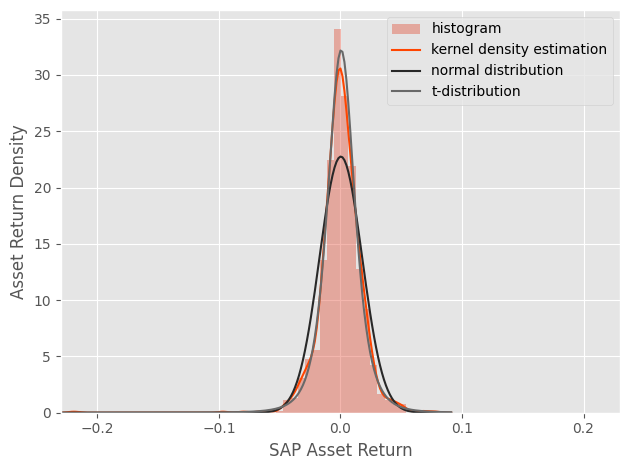

In [55]:
#histogram - closing prices of sap
sns.distplot(data_dict['SAP_DE']['1d_return'], hist = True, kde = False, bins = bins, label = 'histogram', norm_hist = True)
sns.distplot(data_dict['SAP_DE']['1d_return'], hist = False, kde = True, color= 'orangered', label = 'kernel density estimation')
sns.distplot(data_dict['SAP_DE']['1d_return'], hist = False, kde = False, fit = stats.norm, label = 'normal distribution')
sns.distplot(data_dict['SAP_DE']['1d_return'], fit_kws={"color":"dimgrey"}, hist = False, kde = False, fit = stats.t, color = 'black', label = 't-distribution')
plt.xlabel('SAP Asset Return')
plt.ylabel('Asset Return Density')
plt.xlim(-0.23, 0.23)
plt.legend()
plt.tight_layout()
#plt.savefig('hist_ar_sap.png')

In [57]:
#basic figures about sap asset returns
print('Mean of SAP (Asset Return Series):',round((data_dict['SAP_DE']['1d_return']).mean(),6))
print('Standard Deviation of SAP (Asset Return Series):',round((data_dict['SAP_DE']['1d_return']).std(),6))
print('Average Daily Fluctuation of SAP (Asset Return Series):',round((abs(data_dict['SAP_DE']['1d_return'])).mean(),6))

Mean of SAP (Asset Return Series): 0.000325
Standard Deviation of SAP (Asset Return Series): 0.017545
Average Daily Fluctuation of SAP (Asset Return Series): 0.011828


In [65]:
#hyperparameter for acf & pacf plots
lags = 12

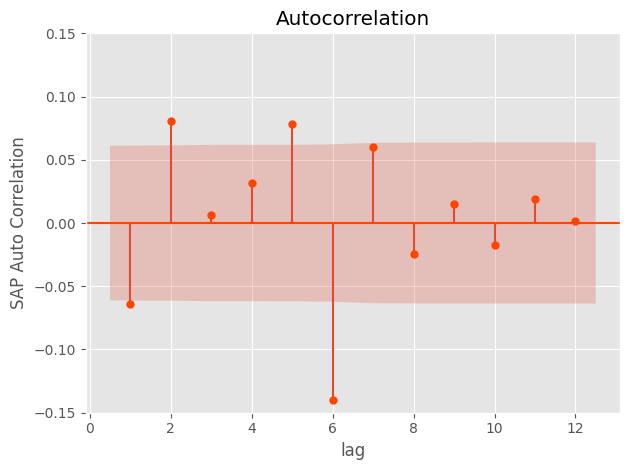

In [72]:
#autocorrelation plot - asset return of dax
plot_acf(data_dict['SAP_DE']['1d_return'][:-1], alpha=0.05, lags=lags, zero = False, color = 'orangered')
plt.xlabel('lag')
plt.ylabel('SAP Auto Correlation')
plt.ylim(-0.15, 0.15)
plt.tight_layout()
#plt.savefig('acf_ar_dax.png')

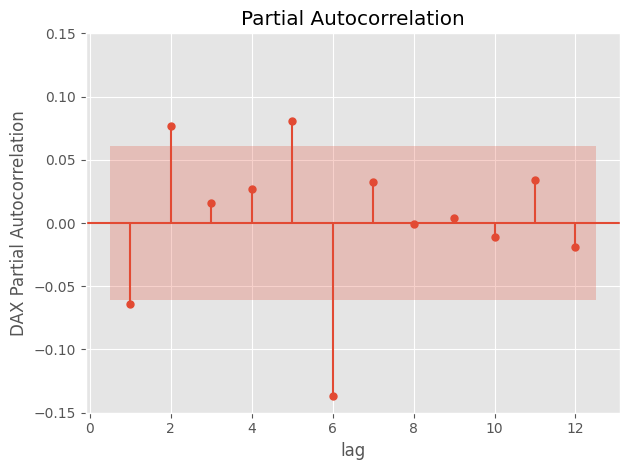

In [71]:
#partial autocorrelation plot - asset return of dax
plot_pacf(data_dict['SAP_DE']['1d_return'][:-1], alpha=0.05, lags=lags, zero = False)
plt.xlabel('lag')
plt.ylabel('DAX Partial Autocorrelation')
plt.ylim(-0.15, 0.15)
plt.tight_layout()
#plt.savefig('pacf_ar_dax.png')